In [1]:
%matplotlib inline

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from collections import OrderedDict

# others
import numpy as np
import pandas as pd

In [2]:
# Multi-layer Perceptron
class DNN(torch.nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth
    ):
        super(DNN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', torch.nn.ELU()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, torch.nn.ELU()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

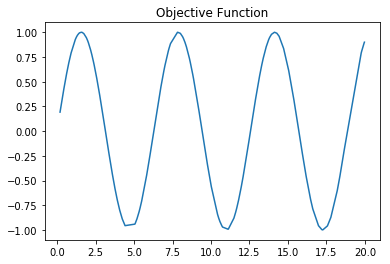

In [3]:
x = torch.empty(200).uniform_(0, 20)
y = torch.sin(x)
sns.lineplot(x=x, y=y)
plt.title('Objective Function')
plt.show()

In [4]:
device = torch.device('cuda')

trainX = x.view(-1, 1).to(device)
trainY = y.view(-1, 1).to(device)

In [5]:
D_in  = trainX.shape[1]
D_out = trainY.shape[1]
H = 50
Depth = 5
NUMEPOCHS = 1000
Batch_size = int(trainX.shape[0] / 10)

# get training data loader
data_train_loader = DataLoader(
    list(zip(trainX, trainY)), 
    batch_size=Batch_size, 
    shuffle=True
)

print('input dimension =', D_in)
print('output dimension =', D_out)
print('hidden layer size =', H)
print('depth =', Depth)
print('training epochs =', NUMEPOCHS)
print('batch size =', Batch_size)

print('----------------------------------')

input dimension = 1
output dimension = 1
hidden layer size = 50
depth = 5
training epochs = 1000
batch size = 20
----------------------------------


In [6]:
%%time

# Compile model
model = DNN(D_in, H, D_out, Depth).to(device)

# Loss Function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = optim.Adamax(model.parameters())

CPU times: user 873 µs, sys: 494 µs, total: 1.37 ms
Wall time: 1.07 ms


In [7]:
def pde_loss(inputs, outputs):
    dy_dx = torch.autograd.grad(
        inputs=inputs, 
        outputs=outputs, 
        grad_outputs=torch.ones_like(outputs)
    )[0]
    true = torch.cos(inputs).detach() # defined by true derivatives
    return criterion(dy_dx, true)

In [8]:
%%time

from tqdm import tqdm

# For Supervising Losses
mse_losses = np.zeros(NUMEPOCHS)
pde_losses = np.zeros(NUMEPOCHS)
# Train the model
for epoch in range(NUMEPOCHS):
    for batchX, batchY in data_train_loader: 
        # Forward pass
        outputs = model(batchX)
        loss = criterion(outputs, batchY)
        
        sample = torch.empty(200).uniform_(0, 50).view(-1, 1).to(device)
        sample.requires_grad = True
        loss_pde = pde_loss(sample, model(sample))
        loss += 1e5 * loss_pde
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # record the loss history
    mse_losses[epoch] = criterion(model(trainX), trainY).item()
    pde_losses[epoch] = loss_pde.item()
    
    if epoch % 100 == 0:
        print(epoch, mse_losses[epoch], pde_losses[epoch])

0 0.47242432832717896 0.467879056930542
100 0.11123088002204895 0.35993170738220215
200 0.0014365226961672306 0.3223465383052826
300 0.0011002771789208055 0.28079119324684143
400 0.010109436698257923 0.3420649766921997
500 0.00010594388731988147 0.3156259059906006
600 7.470724085578695e-05 0.30562105774879456
700 0.0006844797753728926 0.32275810837745667
800 0.0001854337751865387 0.33932390809059143
900 0.0006494484841823578 0.32329437136650085
CPU times: user 1min 18s, sys: 1.28 s, total: 1min 19s
Wall time: 1min 20s


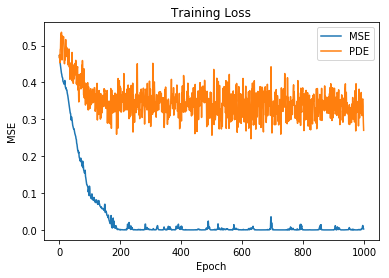

In [9]:
sns.lineplot(data=mse_losses, label="MSE")
sns.lineplot(data=pde_losses, label="PDE")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training Loss')
plt.show()

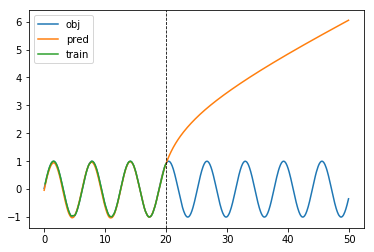

In [10]:
testX = torch.empty(2000).uniform_(0, 50).view(-1, 1).to(device)

test = testX.detach().cpu().numpy().ravel()
pred = model(testX).detach().cpu().numpy().ravel()
train = trainX.detach().cpu().numpy().ravel()

sns.lineplot(x=test, y=np.sin(test), label='obj')
sns.lineplot(x=test, y=pred, label='pred')
sns.lineplot(x=train, y=np.sin(train), label='train')

plt.axvline(x=20, color='k', linestyle='--', linewidth=0.8)

plt.show()

In [11]:
testX.requires_grad = True
outputs = model(testX)

dy_dx = torch.autograd.grad(
    inputs=testX, 
    outputs=outputs, 
    grad_outputs=torch.ones_like(outputs)
)[0].cpu().numpy()
dy_dx

array([[0.12118372],
       [0.12007082],
       [0.16824014],
       ...,
       [0.11826512],
       [0.7142788 ],
       [0.13595916]], dtype=float32)

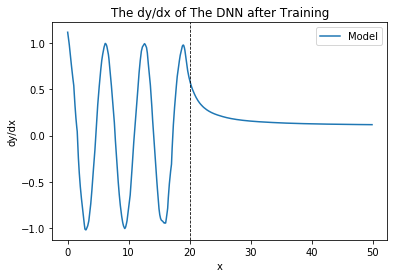

In [12]:
sns.lineplot(
    x=testX.detach().cpu().numpy().ravel(), 
    y=dy_dx.ravel(),
    label='Model'
)

plt.axvline(x=20, color='k', linestyle='--', linewidth=0.8)
plt.title("The dy/dx of The DNN after Training")
plt.xlabel("x")
plt.ylabel("dy/dx")
plt.show()